In [1]:
from fastai.vision.all import *
from fastai.data.transforms import *
import matplotlib.pyplot as plt
from PIL import ImageOps
import gc

I am processing data from many different track sessions so we are trying to make a generalised model instead of a specific one.
I am also spliting the data from each track run into 3 sections in a contiguous fashion.
This is because (I think) data from one image to the next is memorised by the model and predicted. I have made the first 70% of the data used in training and the next 20% used in Validation and the last 10% used for testing. 
This is based on the first chapter of the FastAI Book first chapter and this article https://www.learnopencv.com/bias-variance-tradeoff-in-machine-learning/

I want to implement this where in our case we take the steering data that is not stright and multiply it so we can get better steering 
https://towardsdatascience.com/fastai-bag-of-tricks-experiments-with-a-kaggle-dataset-part-1-135e46da72f2
From this paper https://arxiv.org/pdf/1710.05381.pdf

In [2]:
path = 'data/'
csv = path + '/labels.csv'
np.random.seed(42)

### Loading Data as it takes ages

In [3]:
df = pd.read_csv('donkey_linear.csv')
print(df.shape)
df.head()

(72006, 6)


,Unnamed: 0,image,angle,throttle,validation_set,test_set
0,0,data/Andrew Kew traffic School/tub_11_19-11-03/1_cam-image_array_.jpg,-0.029012,0.008523,False,False
1,1,data/Andrew Kew traffic School/tub_11_19-11-03/2_cam-image_array_.jpg,-0.029012,0.008523,False,False
2,2,data/Andrew Kew traffic School/tub_11_19-11-03/3_cam-image_array_.jpg,-0.029012,0.077458,False,False
3,3,data/Andrew Kew traffic School/tub_11_19-11-03/4_cam-image_array_.jpg,-0.029012,0.077458,False,False
4,4,data/Andrew Kew traffic School/tub_11_19-11-03/5_cam-image_array_.jpg,-0.029012,0.124850,False,False


In [4]:
df_test = df[df['test_set']]
#df = df[~df['test_set']]
#print(df.shape)
#print(df_test.shape)

In [5]:
class RandFlip(RandTransform):
    def __init__(self, p=1.0, **kwargs):
        super().__init__(p, **kwargs)
    def encodes(self, o: Tensor): 
        return Tensor([-o[0], o[1]])   # this reverses the target steering value
    def encodes(self, o: PILImage):
        return ImageOps.mirror(o)     # this mirrors the input image

In [6]:
def SplitterNonSplitter():
    def _inner(o):
        indexs = range(o.shape[0])
        return L(indexs, use_list=True), L(indexs, use_list=True)
    return _inner

In [7]:
#valid_idx = (df.iloc[:,'validation_set'] if isinstance('validation_set', int) else df['validation_set']).values.astype('bool')

nav = DataBlock(
    blocks     = (ImageBlock, ImageBlock),

    get_items=get_image_files,
    splitter   = RandomSplitter(valid_pct=0.2, seed=100),
    #item_tfms  = [RandFlip(.5)],
    #batch_tfms = [Normalize()]
    #aug_transforms(do_flip=False, flip_vert=False, max_rotate=0, 
    #                          min_zoom=0, max_zoom=0, max_warp=0, p_affine=0,
    #                          max_lighting=0.8, p_lighting=0.8, xtra_tfms=Normalize()) 
)

dls = nav.dataloaders(path, bs=128)
#print(dls.train_ds[0])
#dls._one_pass()
print(len(dls.train_ds))
print(len(dls.valid_ds))
#test_dl = dls.test_dl(df_test, with_labels=True)


57605
14401


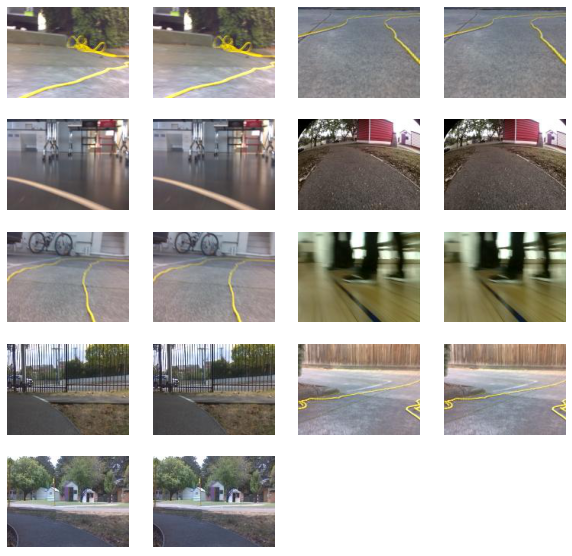

In [8]:
dls.show_batch(nrows=5,ncols=2,figsize=(10,10))
 

In [9]:
def plot_loss_stats(learn):
    learn.recorder.plot_loss()
    learn.show_results(nrows=5, figsize=(10,10))

In [10]:
def graph_preds():
    preds, tgt = learn.get_preds(dl=test_dl)
    print(rmse(preds,tgt))
    #Steering
    plt.title("Target vs Predicted Steering", fontsize=18, y=1.0)
    plt.xlabel("Target", fontsize=14, labelpad=15)
    plt.ylabel("Predicted", fontsize=14, labelpad=15)
    plt.plot(tgt.T[0], preds.T[0],'bo')
    plt.plot([-1,1],[-1,1],'r', linewidth = 4)
    plt.show()
    
    #Throttle
    plt.title("Target vs Predicted Throttle", fontsize=18, y=1.02)
    plt.xlabel("Target", fontsize=14, labelpad=15)
    plt.ylabel("Predicted", fontsize=14, labelpad=15)
    plt.plot(tgt.T[1], preds.T[1],'bo')
    plt.plot([0,1],[0,1],'r', linewidth = 4)
    plt.show()    

# define the NN architecture
class VaeEncoder(nn.Module):
    def __init__(self):
        super(VaeEncoder, self).__init__()
        ## encoder ##
        self.fc1 = nn.Linear(height * width * channel, intermediate_dim)
        # defining the mean of the latent space
        self.fc_mean = nn.Linear(intermediate_dim, latent_dim)
        # defining the log variance of the latent space
        self.fc_log_var = nn.Linear(intermediate_dim, latent_dim)
        
    def sampling(self, z_mean, z_log_var):
        epsilon = torch.randn(z_mean.shape[0], latent_dim).cuda()
        return z_mean + torch.exp(z_log_var / 2) * epsilon
    
    def forward(self, x):
        # flatten images
        x = x.view(x.size(0), -1)
        #print(x.shape)
        h = F.relu(self.fc1(x))
        z_mean = self.fc_mean(h)
        z_log_var = self.fc_log_var(h)
        z = self.sampling(z_mean, z_log_var)
        return z, z_mean, z_log_var
    
class VaeDecoder(nn.Module):
    def __init__(self):
        super(VaeDecoder, self).__init__()
        # linear layer (encoding_dim -> input size)
        self.fc2 = nn.Linear(latent_dim, intermediate_dim)
        self.fc3 = nn.Linear(intermediate_dim, channel * height * width)
            
    def forward(self, z):
        decoder_h = F.relu(self.fc2(z))
        # output layer (sigmoid for scaling from 0 to 1)
        x_decoded = torch.sigmoid(self.fc3(decoder_h))
        #print(x.shape)
        # reshape to 28x28
        x_out = x_decoded.view(x_decoded.size(0), channel, height, width)
        #print(x_out.shape)
        return x_out

class Vae(nn.Module):
    def __init__(self):
        super(Vae, self).__init__()
        self.encoder = VaeEncoder()
        self.decoder = VaeDecoder()
            
    def forward(self, x):
        x,m,v = self.encoder(x)
        x = self.decoder(x)
        #print(x.shape)
        return x,m,v    
    
# initialize the NN
height = 120
width = 160
channel = 3
intermediate_dim = 256
latent_dim = 2
model = Vae()
print(model)

In [39]:
# define the NN architecture
class VaeEncoder(nn.Module):
    def __init__(self):
        super(VaeEncoder, self).__init__()
        ## encoder ##
        #self.fc1 = nn.Linear(height * width * channel, intermediate_dim)
        self.layer1 = ConvLayer(3, 24, stride=2, ks=5)
        self.layer2 = ConvLayer(24, 32, stride=2, ks=5)
        self.layer3 = ConvLayer(32, 64, stride=2, ks=5)
        self.layer4 = ConvLayer(64, 64, stride=2, ks=5)
        self.layer5 = ConvLayer(64, 64, stride=2, ks=3)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = Flatten()
        # defining the mean of the latent space
        self.fc_mean = nn.Linear(intermediate_dim, latent_dim)
        # defining the log variance of the latent space
        self.fc_log_var = nn.Linear(intermediate_dim, latent_dim)
        
    def sampling(self, z_mean, z_log_var):
        epsilon = torch.randn(z_mean.shape[0], latent_dim).cuda()
        return z_mean + torch.exp(z_log_var / 2) * epsilon
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.pool(x)
        h = self.flatten(x)
        z_mean = self.fc_mean(h)
        z_log_var = self.fc_log_var(h)
        z = self.sampling(z_mean, z_log_var)
        return z, z_mean, z_log_var
    
class VaeDecoder(nn.Module):
    def __init__(self):
        super(VaeDecoder, self).__init__()
        # linear layer (encoding_dim -> input size)
        self.fc2 = nn.Linear(latent_dim, intermediate_dim) #intermediate_dim
        
        self.fc3 = nn.Linear(intermediate_dim, 1024)
        self.layer6 = ConvLayer(3, 6, stride=2, ks=5, transpose=True)
        self.layer7 = ConvLayer(24, 32, stride=2, ks=5, transpose=True)
        self.layer8 = ConvLayer(32, 64, stride=2, ks=5, transpose=True)
        self.layer9 = ConvLayer(64, 32, stride=3, ks=5, transpose=True)
        self.layer10 = ConvLayer(32, 24, stride=3, ks=5, transpose=True)
        self.fc4 = nn.Linear(1024, channel * height * width) #intermediate_dim
        self.flatten = Flatten()
        
    def forward(self, z):
        #we take in a 
        x = F.relu(self.fc2(z))
        x = F.relu(self.fc3(x))
        #x = x.view(x.size(0), channel, 4, 5)
        #print("new shape ", x.shape)
        #x = self.layer6(x)
        #print("layer6 ", x.shape, x.size(0))
        #x = self.layer7(x)
        #print("layer7 ", x.shape, x.size(0))
        #x = self.layer8(x)
        #print("layer8 ", x.shape, x.size(0))
        #x = self.layer9(x)
        #print("layer9 ", x.shape, x.size(0))
        
        #x = self.layer10(x)
        #print("layer10 ", x.shape, x.size(0))
        #x = self.flatten(x)
        #print("flatten ", x.shape, x.size(0))
        
        # output layer (sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.fc4(x))
        
        #print("out " + str(x.shape))
        
        x = x.view(x.size(0), channel, height, width)
        #print(x_out.shape)
        return x

class Vae(nn.Module):
    def __init__(self):
        super(Vae, self).__init__()
        self.encoder = VaeEncoder()
        self.decoder = VaeDecoder()
            
    def forward(self, x):
        x,m,v = self.encoder(x)
        #print("Decode " + str(x.shape))
        x = self.decoder(x)
        #print(x.shape)
        return x,m,v    
    
# initialize the NN
height = 120
width = 160
channel = 3
intermediate_dim = 64 #64 for linear
latent_dim = 1
model = Vae()
print(model)

Vae(
  (encoder): VaeEncoder(
    (layer1): ConvLayer(
      (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer2): ConvLayer(
      (0): Conv2d(24, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer3): ConvLayer(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer4): ConvLayer(
      (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer5): ConvLayer(
      (0): Conv2d(64, 64, kern

In [40]:
class LossFunc(nn.Module):
    def __init__(self):
        super(LossFunc, self).__init__()
        return

    def forward(self, pred, target):
        x, z_mean, z_log_var=pred
        mse_loss = nn.MSELoss()(x,target)
        kl_loss = - 0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var), 1)
        # KL (latent) loss scaled to match mse (reconstruction) loss
        vae_loss = torch.mean(kl_loss) / 57600 + mse_loss 
        return vae_loss

In [41]:
learn = Learner(dls, model, loss_func=LossFunc())
learn.summary()

Vae (Input shape: ['128 x 3 x 120 x 160'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               128 x 24 x 60 x 80   1,800      True      
________________________________________________________________
BatchNorm2d          128 x 24 x 60 x 80   48         True      
________________________________________________________________
ReLU                 128 x 24 x 60 x 80   0          False     
________________________________________________________________
Conv2d               128 x 32 x 30 x 40   19,200     True      
________________________________________________________________
BatchNorm2d          128 x 32 x 30 x 40   64         True      
________________________________________________________________
ReLU                 128 x 32 x 30 x 40   0          False     
________________________________________________________________
Conv2d               128 x 64 x 15 x 20   51,200     True      
_______________________________________________________

Minimum/10: 5.25e-02, steepest point: 6.92e-02


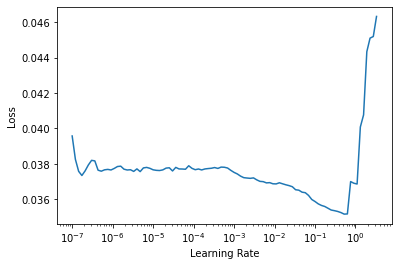

In [42]:
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

image_size = dls.one_batch()[0].shape
print(image_size)
vae = VAE(image_size[-2], image_size[-1], emb_size)
my_learner = Learner(dls,
                     vae,
                     #opt_func=torch.optim.Adam,
                     loss_func=vae.vae_loss_function)
my_learner.summary()


In [43]:
learn.fit(15, lr=5.25e-02)

epoch,train_loss,valid_loss,time
0,0.024904,0.026066,00:38
1,0.024315,0.024588,00:40
2,0.023667,0.023487,00:40
3,0.023202,0.023719,00:40
4,0.023384,0.023411,00:41
5,0.023340,0.023237,00:40
6,0.023177,0.022929,00:39
7,0.023125,0.023032,00:39
8,0.022795,0.023674,00:39
9,0.022998,0.023706,00:39


class VaeDecoder(nn.Module):
    def __init__(self):
        super(VaeDecoder, self).__init__()
        # linear layer (encoding_dim -> input size)
        self.fc2 = nn.Linear(latent_dim, intermediate_dim) #intermediate_dim
        
        self.fc3 = nn.Linear(intermediate_dim, 858)
        self.layer6 = ConvLayer(3, 6, stride=2, ks=5, transpose=True)
        self.layer7 = ConvLayer(24, 32, stride=2, ks=5, transpose=True)
        self.layer8 = ConvLayer(32, 64, stride=2, ks=5, transpose=True)
        self.layer9 = ConvLayer(64, 32, stride=3, ks=5, transpose=True)
        self.layer10 = ConvLayer(32, 24, stride=3, ks=5, transpose=True)
        self.fc4 = nn.Linear(858, channel * height * width) #intermediate_dim
        self.flatten = Flatten()
        
    def forward(self, z):
        #we take in a 
        x = F.relu(self.fc2(z))
        x = F.relu(self.fc3(x))
        #x = x.view(x.size(0), channel, 4, 5)
        #print("new shape ", x.shape)
        #x = self.layer6(x)
        #print("layer6 ", x.shape, x.size(0))
        #x = self.layer7(x)
        #print("layer7 ", x.shape, x.size(0))
        #x = self.layer8(x)
        #print("layer8 ", x.shape, x.size(0))
        #x = self.layer9(x)
        #print("layer9 ", x.shape, x.size(0))
        
        #x = self.layer10(x)
        #print("layer10 ", x.shape, x.size(0))
        #x = self.flatten(x)
        #print("flatten ", x.shape, x.size(0))
        
        # output layer (sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.fc4(x))
        
        #print("out " + str(x.shape))
        
        x = x.view(x.size(0), channel, height, width)
        #print(x_out.shape)
        return x
epoch	train_loss	valid_loss	time
0	0.021341	0.021011	00:35
1	0.020382	0.020465	00:37
2	0.019692	0.019594	00:39
3	0.019268	0.019276	00:39
4	0.018925	0.019969	00:39
5	0.018807	0.018489	00:38
6	0.018459	0.018341	00:39
7	0.018190	0.018001	00:38
8	0.017953	0.018102	00:38
9	0.017909	0.018177	00:39

class VaeDecoder(nn.Module):
    def __init__(self):
        super(VaeDecoder, self).__init__()
        # linear layer (encoding_dim -> input size)
        self.fc2 = nn.Linear(latent_dim, 3 * 4 * 5) #intermediate_dim
        
        self.fc3 = nn.Linear(intermediate_dim, channel * height * width)
        self.layer6 = ConvLayer(3, 24, stride=2, ks=(6,7), transpose=True)
        self.layer7 = ConvLayer(24, 32, stride=2, ks=(6,7), transpose=True)
        self.layer8 = ConvLayer(32, 64, stride=2, ks=(4,7), transpose=True)
        self.layer9 = ConvLayer(64, 64, stride=2, ks=(4,7), transpose=True)
        self.layer10 = ConvLayer(64, 3, stride=1, ks=(3,6), transpose=True)
            
    def forward(self, z):
        #we take in a 
        x = F.relu(self.fc2(z))
        x = x.view(x.size(0), 3, 4, 5)
        #print("new shape ", x.shape)
        x = self.layer6(x)
        #print("layer6 ", x.shape, x.size(0))
        x = self.layer7(x)
        #print("layer7 ", x.shape, x.size(0))
        x = self.layer8(x)
        #print("layer8 ", x.shape, x.size(0))
        x = self.layer9(x)
        #print("layer9 ", x.shape, x.size(0))
        x = self.layer10(x)
        #print("layer10 ", x.shape, x.size(0))
        
        # output layer (sigmoid for scaling from 0 to 1)
        #x_decoded = torch.sigmoid(self.fc3(x))
        
        #print("out " + str(x.shape))
        
        #x_out = x.view(x.size(0), channel, height, width)
        #print(x_out.shape)
        return x
        
Fresh
epoch	train_loss	valid_loss	time
0	0.053166	0.048931	02:02
1	0.030380	0.029271	02:00
2	0.024660	0.023984	02:01
3	0.022788	0.022339	02:01
4	0.021886	0.021528	02:02
5	0.021250	0.020977	02:02
6	0.021087	0.020879	02:02
7	0.020675	0.020608	01:55
8	0.020672	0.020353	01:53
9	0.020415	0.020259	01:53

With Norm
epoch	train_loss	valid_loss	time
0	0.953036	0.949193	01:58
1	0.916660	0.900008	01:57
2	0.852805	0.846104	02:01
3	0.840421	0.826267	02:01
4	0.821934	0.815106	02:00
5	0.815170	0.811243	02:01
6	0.812174	0.809802	02:02
7	0.809619	0.803596	02:02
8	0.800406	0.800289	02:04
9	0.800443	0.798512	02:05

In [18]:
learn.save('vae_full_full')

Path('models/vae_full_full.pth')

In [17]:
#learn.load('vae_full')

RuntimeError: Error(s) in loading state_dict for Vae:
	Missing key(s) in state_dict: "decoder.fc4.weight", "decoder.fc4.bias". 
	size mismatch for decoder.fc2.weight: copying a param with shape torch.Size([60, 2]) from checkpoint, the shape in current model is torch.Size([64, 2]).
	size mismatch for decoder.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.fc3.weight: copying a param with shape torch.Size([57600, 64]) from checkpoint, the shape in current model is torch.Size([858, 64]).
	size mismatch for decoder.fc3.bias: copying a param with shape torch.Size([57600]) from checkpoint, the shape in current model is torch.Size([858]).
	size mismatch for decoder.layer6.0.weight: copying a param with shape torch.Size([3, 24, 6, 7]) from checkpoint, the shape in current model is torch.Size([3, 6, 5, 5]).
	size mismatch for decoder.layer6.1.weight: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for decoder.layer6.1.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for decoder.layer6.1.running_mean: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for decoder.layer6.1.running_var: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for decoder.layer7.0.weight: copying a param with shape torch.Size([24, 32, 6, 7]) from checkpoint, the shape in current model is torch.Size([24, 32, 5, 5]).
	size mismatch for decoder.layer8.0.weight: copying a param with shape torch.Size([32, 64, 4, 7]) from checkpoint, the shape in current model is torch.Size([32, 64, 5, 5]).
	size mismatch for decoder.layer9.0.weight: copying a param with shape torch.Size([64, 64, 4, 7]) from checkpoint, the shape in current model is torch.Size([64, 32, 5, 5]).
	size mismatch for decoder.layer9.1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decoder.layer9.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decoder.layer9.1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decoder.layer9.1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decoder.layer10.0.weight: copying a param with shape torch.Size([64, 3, 3, 6]) from checkpoint, the shape in current model is torch.Size([32, 24, 5, 5]).
	size mismatch for decoder.layer10.1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for decoder.layer10.1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for decoder.layer10.1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for decoder.layer10.1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([24]).

In [46]:
def show_results(ds_idx=1, dl=None, max_n=9, shuffle=True, **kwargs):
    if dl is None: dl = learn.dls[ds_idx].new(shuffle=shuffle)
    b = dl.one_batch()
    _,_,preds = learn.get_preds(dl=[b], with_decoded=True)
    learn.dls.show_results(b, preds[0], max_n=max_n, **kwargs)

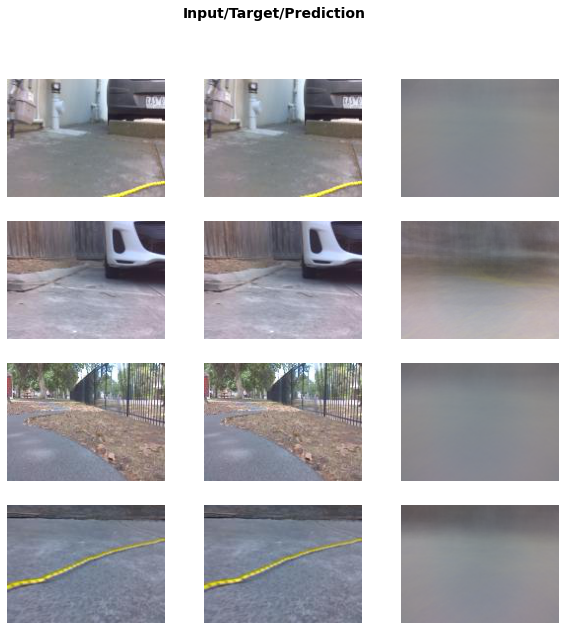

In [49]:
show_results(max_n=6, figsize=(10,10))

In [ ]:
nav = DataBlock(
    blocks     = (ImageBlock(cls=PILImage) , RegressionBlock(n_out=2)),
    get_x      = ColReader('image', pref=''), 
    get_y      = ColReader(['angle','throttle']),
    splitter   = ColSplitter('validation_set'))

data_test = nav.dataloaders(df, bs=512)

In [ ]:
x_test, y_test = data_test.one_batch()
x_test_encoded,_,_ = model.encoder(x_test)
x_test_encoded = x_test_encoded.detach().cpu().numpy()
print(y_test[,:].shape)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test.detach().cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.show()